<a href="https://colab.research.google.com/github/Aleksiiej/Machine-Learning/blob/main/Classification_of_mushroom_species.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             ConfusionMatrixDisplay,
                             RocCurveDisplay)

In [19]:
# reading data from .csv file

df = pd.read_csv('agaricus-lepiota.data')
df.columns = ['class',
              'cap-shape',
              'cap-surface',
              'cap-color',
              'bruises?',
              'odor',
              'gill-attachment',
              'gill-spacing',
              'gill-size',
              'gill-color',
              'stalk-shape',
              'stalk-root',
              'stalk-surface-above-ring',
              'stalk-surface-below-ring',
              'stalk-color-above-ring',
              'stalk-color-below-ring',
              'veil-type',
              'veil-color',
              'ring-number',
              'ring-type',
              'spore-print-color',
              'population',
              'habitat']

In [20]:
# initial analysis of data

print(df.info())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8123 non-null   object
 1   cap-shape                 8123 non-null   object
 2   cap-surface               8123 non-null   object
 3   cap-color                 8123 non-null   object
 4   bruises?                  8123 non-null   object
 5   odor                      8123 non-null   object
 6   gill-attachment           8123 non-null   object
 7   gill-spacing              8123 non-null   object
 8   gill-size                 8123 non-null   object
 9   gill-color                8123 non-null   object
 10  stalk-shape               8123 non-null   object
 11  stalk-root                8123 non-null   object
 12  stalk-surface-above-ring  8123 non-null   object
 13  stalk-surface-below-ring  8123 non-null   object
 14  stalk-color-above-ring  

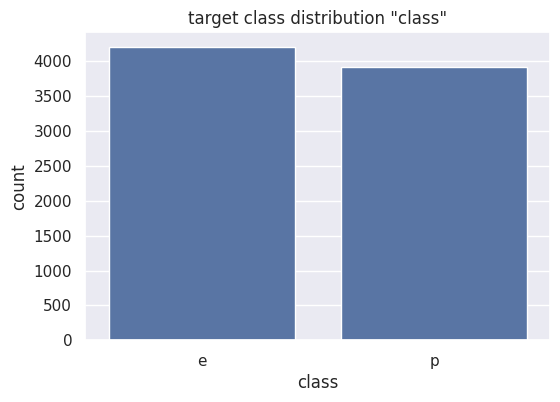

       class cap-shape cap-surface cap-color bruises?  odor gill-attachment  \
count   8123      8123        8123      8123     8123  8123            8123   
unique     2         6           4        10        2     9               2   
top        e         x           y         n        f     n               f   
freq    4208      3655        3244      2283     4748  3528            7913   

       gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
count          8123      8123       8123  ...                     8123   
unique            2         2         12  ...                        4   
top               c         b          b  ...                        s   
freq           6811      5612       1728  ...                     4935   

       stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
count                    8123                   8123      8123       8123   
unique                      9                      9         1          4   
to

In [21]:
sns.set(rc={'figure.figsize': (6, 4)})
sns.countplot(df, x='class')
plt.title('target class distribution "class"')
plt.show()
print(df.describe())

In [22]:
print(df['odor'].value_counts())
print(df['odor'].unique())

print(df['gill-color'].value_counts())
print(df['gill-color'].unique())

print(df['cap-shape'].value_counts())
print(df['cap-shape'].unique())

odor
n    3528
f    2160
s     576
y     576
a     400
l     400
p     255
c     192
m      36
Name: count, dtype: int64
['a' 'l' 'p' 'n' 'f' 'c' 'y' 's' 'm']
gill-color
b    1728
p    1492
w    1202
n    1048
g     752
h     732
u     492
k     407
e      96
y      86
o      64
r      24
Name: count, dtype: int64
['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
cap-shape
x    3655
f    3152
k     828
b     452
s      32
c       4
Name: count, dtype: int64
['x' 'b' 's' 'f' 'k' 'c']


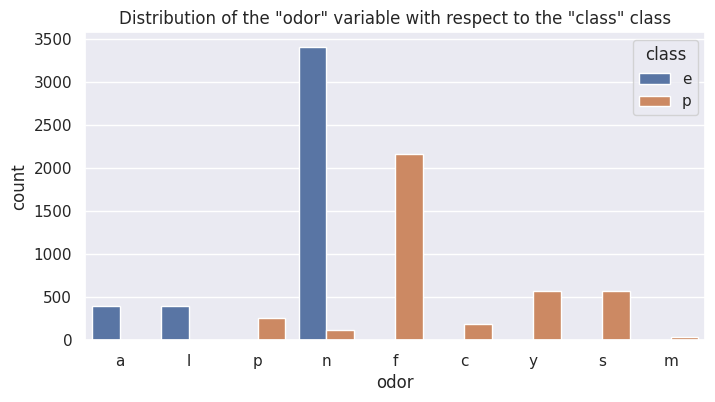

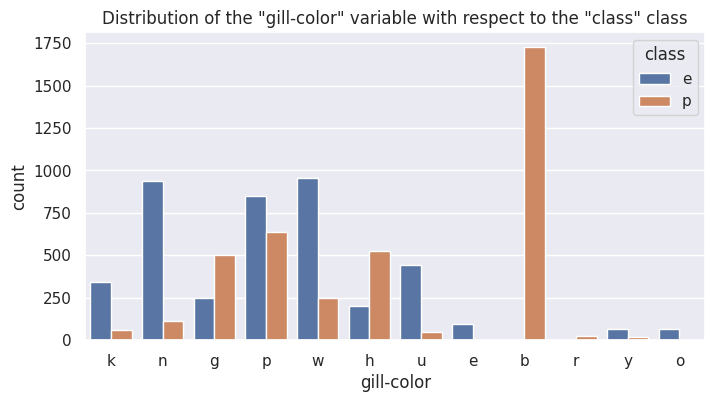

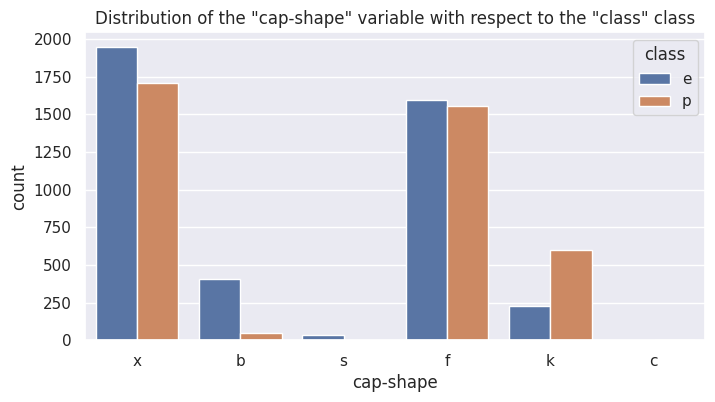

In [23]:
sns.set(rc={'figure.figsize': (8, 4)})
odors_df = pd.DataFrame({'class': df['class'].values.tolist(),
                         'odor': df['odor'].values.tolist()})
sns.countplot(odors_df, x='odor', hue='class')
plt.title('Distribution of the "odor" variable with respect to the "class" class')
plt.show()

gill_color_df = pd.DataFrame({'class': df['class'].values.tolist(),
                              'gill-color': df['gill-color'].values.tolist()})
sns.countplot(gill_color_df, x='gill-color', hue='class')
plt.title('Distribution of the "gill-color" variable with respect to the "class" class')
plt.show()

cap_shape_df = pd.DataFrame({'class': df['class'].values.tolist(),
                             'cap-shape': df['cap-shape'].values.tolist()})
sns.countplot(cap_shape_df, x='cap-shape', hue='class')
plt.title('Distribution of the "cap-shape" variable with respect to the "class" class')
plt.show()

In [24]:
# calculation of Cramer's V coefficient to define how features are corelated with "class" class :-)

def cramers_v(x, y):
  contingency_table = pd.crosstab(x, y)
  chi2_statistic, p_value, dof, expected = chi2_contingency(contingency_table)
  n = contingency_table.sum().sum()
  phi2 = chi2_statistic / n
  r, k = contingency_table.shape
  phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
  k_corr = k - (k - 1) * (k - 2) / (n - 1)
  r_corr = r - (r - 1) * (r - 2) / (n - 1)
  v = np.sqrt(phi2corr / min(k_corr - 1, r_corr - 1))
  return v

cramersVStat = pd.DataFrame(columns=['feature', 'cramersV'])
features = ['odor', 'gill-color', 'cap-shape']
for feature in df.columns[1:]:
  cramersVStat.loc[len(cramersVStat)] = [feature,
                                         cramers_v(df[feature],
                                                   df['class']).round(2)]

print(cramersVStat)

                     feature  cramersV
0                  cap-shape      0.24
1                cap-surface      0.20
2                  cap-color      0.22
3                   bruises?      0.50
4                       odor      0.97
5            gill-attachment      0.13
6               gill-spacing      0.35
7                  gill-size      0.54
8                 gill-color      0.68
9                stalk-shape      0.10
10                stalk-root      0.41
11  stalk-surface-above-ring      0.59
12  stalk-surface-below-ring      0.57
13    stalk-color-above-ring      0.52
14    stalk-color-below-ring      0.51
15                 veil-type       NaN
16                veil-color      0.15
17               ring-number      0.21
18                 ring-type      0.60
19         spore-print-color      0.75
20                population      0.49
21                   habitat      0.44


/tmp/ipython-input-3073786966.py:12: RuntimeWarning: invalid value encountered in scalar divide
  v = np.sqrt(phi2corr / min(k_corr - 1, r_corr - 1))


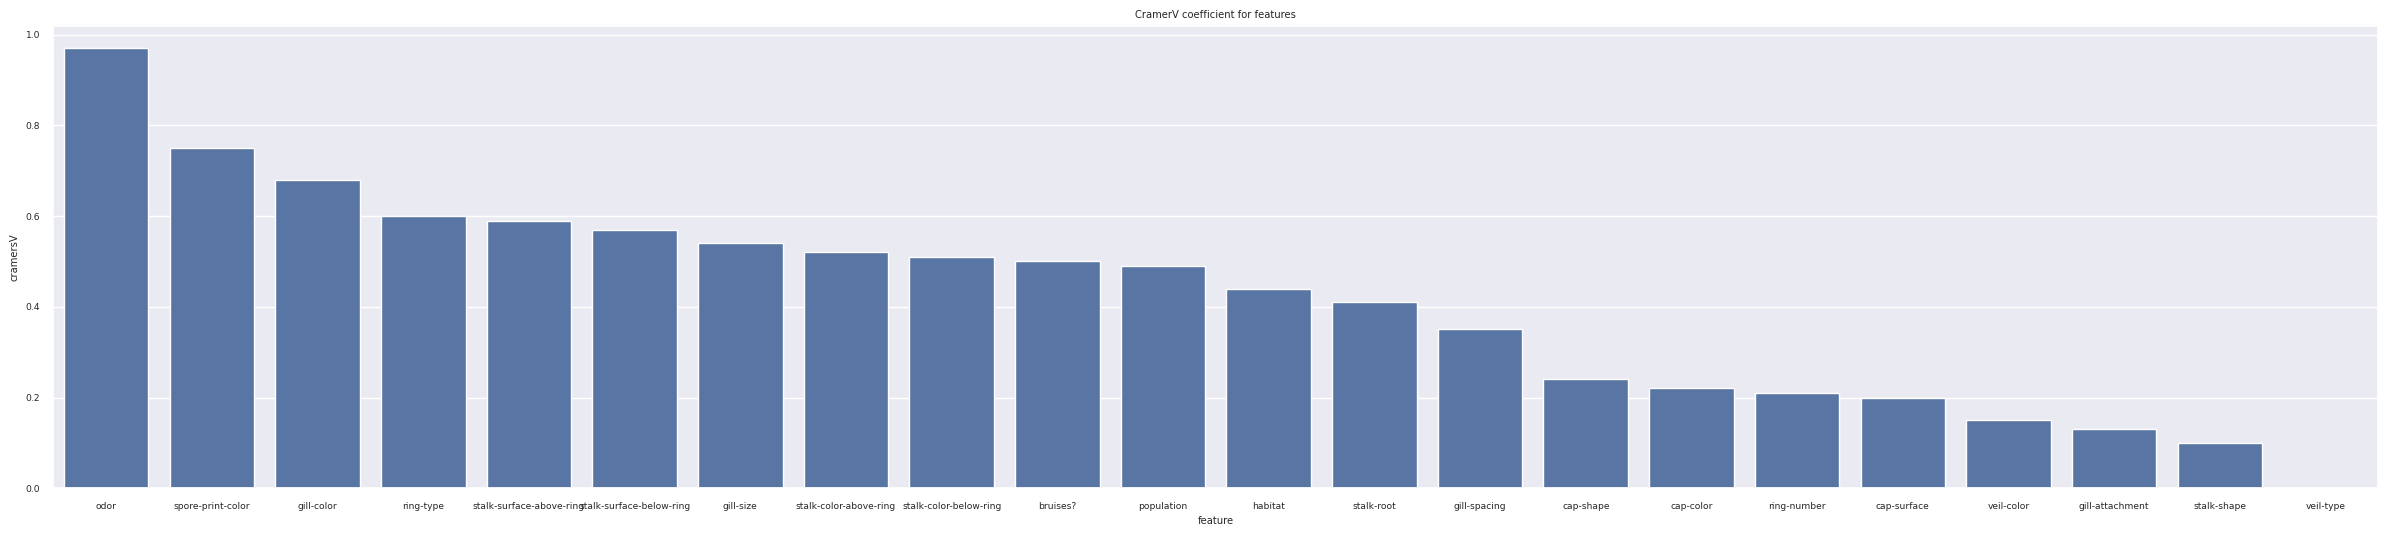

In [25]:
sns.set(rc={'figure.figsize': (30, 6)}, font_scale=0.6)
cramersVStat_sorted = cramersVStat.sort_values(by='cramersV', ascending=False)
sns.barplot(cramersVStat_sorted, x='feature', y='cramersV')
plt.title('CramerV coefficient for features')
plt.show()

In [26]:
# preparing data

le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

df = pd.get_dummies(df, columns=list(df.columns)[1:])

X = df.drop(columns=['class'], axis=1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)



In [27]:
# 2.2.1.4

models = {'LogisticRegression': LogisticRegression().fit(X_train, y_train),
          'DecisionTreeClasifier': DecisionTreeClassifier(max_depth=3).fit(X_train, y_train),
          'RandomForestClassifier': RandomForestClassifier(n_estimators=5, max_depth=2).fit(X_train, y_train),
          'NaiveBayes': CategoricalNB().fit(X_train, y_train),
          'GradientBoosting': GradientBoostingClassifier(n_estimators=1).fit(X_train, y_train)}

In [28]:
# data classification

results = pd.DataFrame(columns=['Model',
                                'Accuracy',
                                'Precision',
                                'Recall',
                                'F1-score'])

for key, value in models.items():
  y_test_pred = value.predict(X_test)
  results.loc[len(results)] = [key,
                               accuracy_score(y_test, y_test_pred),
                               precision_score(y_test, y_test_pred),
                               recall_score(y_test, y_test_pred),
                               f1_score(y_test, y_test_pred)]

In [29]:
# comparison of various data models

print(results)

                    Model  Accuracy  Precision    Recall  F1-score
0      LogisticRegression  1.000000   1.000000  1.000000  1.000000
1   DecisionTreeClasifier  0.981538   0.963750  0.998705  0.980916
2  RandomForestClassifier  0.915077   0.956772  0.860104  0.905866
3              NaiveBayes  0.944615   0.980282  0.901554  0.939271
4        GradientBoosting  0.981538   0.963750  0.998705  0.980916


For more detailed analysis of features I chose Random Forest Classifier.

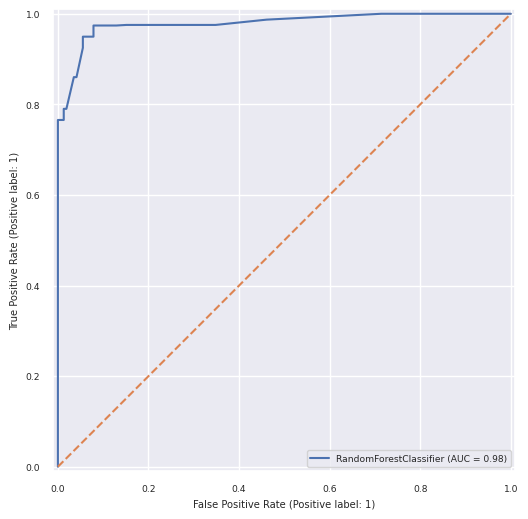

In [30]:
# ROC curve for choosen classification model

RocCurveDisplay.from_estimator(models.get('RandomForestClassifier'), X_test, y_test)
plt.gca().plot([0, 1], [0, 1], '--', c='C1');

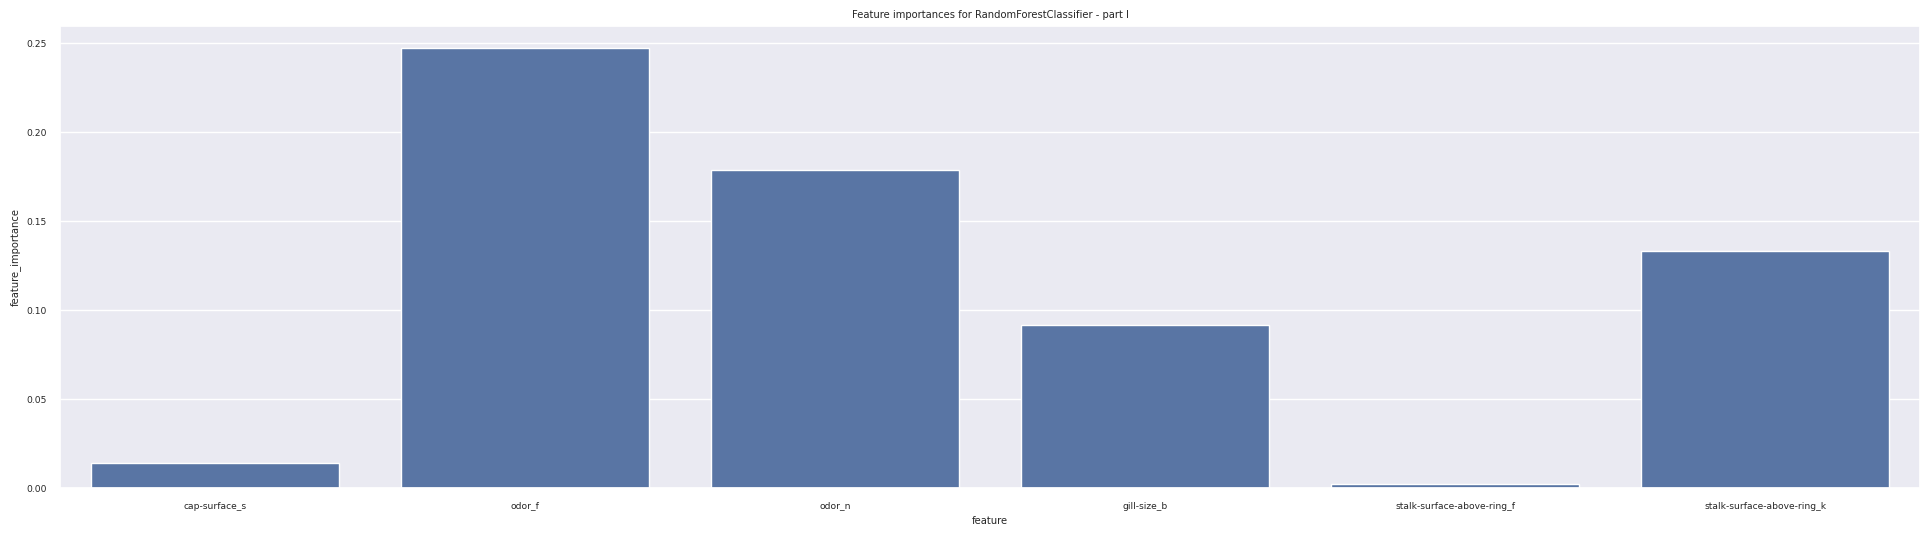

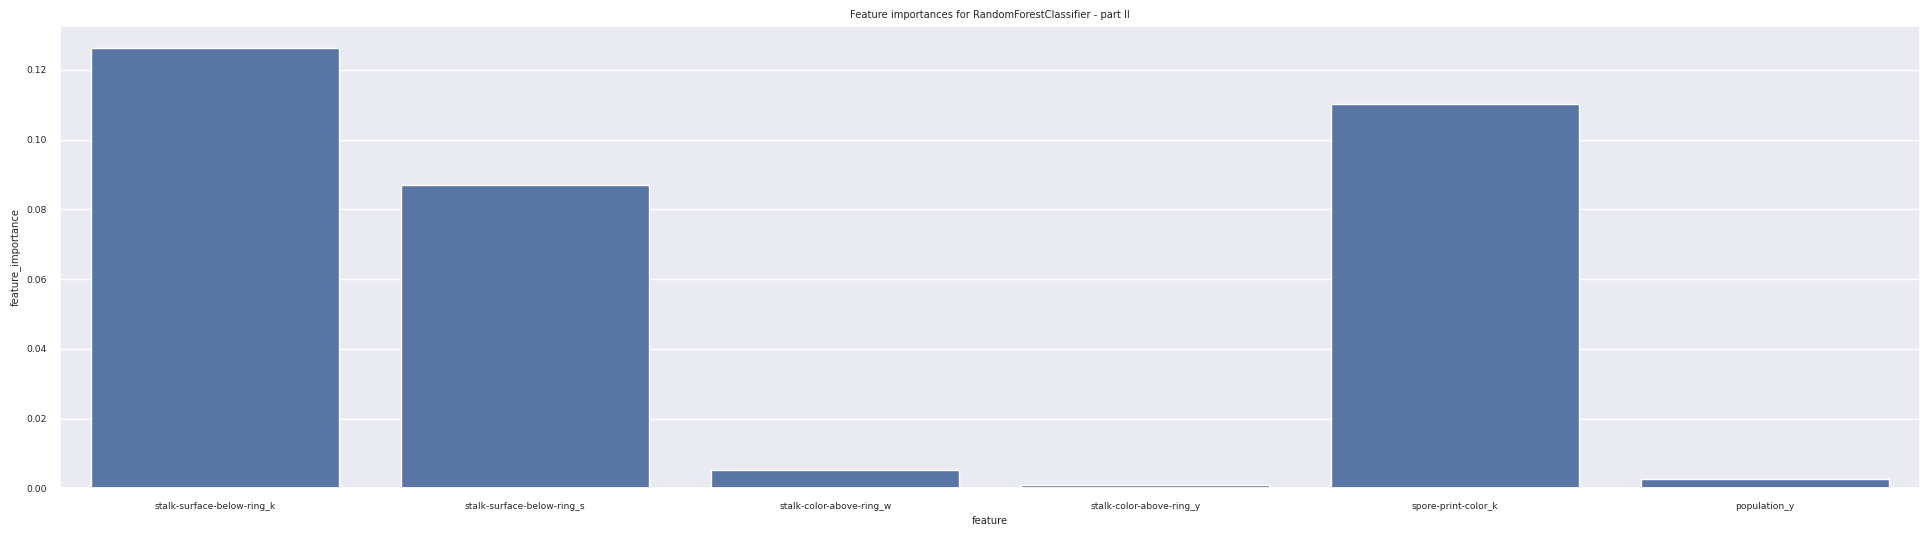

In [31]:
# analysis of features

sns.set(rc={'figure.figsize': (24, 6)}, font_scale=0.6)
df = pd.DataFrame(columns=['feature', 'feature_importance'])
df['feature_importance'] = models.get('RandomForestClassifier').feature_importances_
df['feature'] = X.columns
# filtering features with no impact
df = df[df['feature_importance'] > 0]
sns.barplot(df.iloc[:round(len(df)/2),:], x='feature', y='feature_importance')
plt.title('Feature importances for RandomForestClassifier - part I')
plt.show()
sns.barplot(df.iloc[round(len(df)/2):,:], x='feature', y='feature_importance')
plt.title('Feature importances for RandomForestClassifier - part II')
plt.show()

According to analysis, odor seems to be most important feature distuinguishing toxic from non-toxic mushrooms. Other important features are shape of stalk, color of spores and size of gills.